## Introduction

In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [25]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=110)
torch.set_printoptions(linewidth=110, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 110)

## Cleaning the data

In [3]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
df.fillna(modes, inplace=True)

In [8]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [9]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


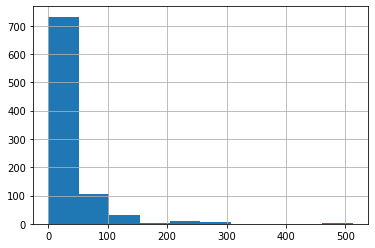

In [10]:
df['Fare'].hist();

In [11]:
df['LogFare'] = np.log(df['Fare']+1)

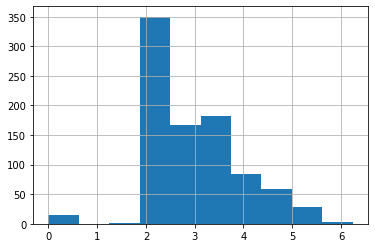

In [12]:
df['LogFare'].hist();

In [13]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [14]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [15]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [16]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


In [17]:
from torch import tensor

t_dep = tensor(df.Survived)

In [18]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [19]:
t_indep.shape

torch.Size([891, 12])

## Setting up a linear model

In [21]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [27]:
t_indep.shape

torch.Size([891, 12])

In [28]:
coeffs.shape

torch.Size([12])

In [26]:
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,
           0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,
           0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,
           0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,
           0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,
           0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,
           0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,
           0.0000,   0.3625],
        ...,
        [-11.5

In [30]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [31]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,
          0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,
          0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,
          0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,
          0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,
          0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,
          0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,
          0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,

In [32]:
preds = (t_indep*coeffs).sum(axis=1)

In [33]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

In [34]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

In [35]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Doing a gradient descent step

In [36]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,
         0.3625], requires_grad=True)

In [37]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [38]:
loss.backward()

In [39]:
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,
         0.2043])

In [40]:
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5197)


## Training the linear model

In [41]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [43]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

In [44]:
def update_coeffs(coeffs, lr): coeffs.sub_(coeffs.grad * lr)

In [45]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [46]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [47]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [48]:
coeffs = train_model(18, lr=0.02)

0.536; 0.532; 0.525; 0.515; 0.503; 0.489; 0.477; 0.466; 0.449; 0.424; 0.396; 0.373; 0.354; 0.338; 0.321; 0.306; 0.297; 0.295; 

In [49]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2335),
 'SibSp': tensor(0.1025),
 'Parch': tensor(0.2530),
 'LogFare': tensor(0.1073),
 'Sex_male': tensor(-0.4166),
 'Sex_female': tensor(0.3314),
 'Pclass_1': tensor(0.8639),
 'Pclass_2': tensor(0.4225),
 'Pclass_3': tensor(0.2875),
 'Embarked_C': tensor(0.1840),
 'Embarked_Q': tensor(0.3267),
 'Embarked_S': tensor(0.1158)}

## Measuring accuracy

In [50]:
preds = calc_preds(coeffs, val_indep)

In [51]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,
         True, False])

In [52]:
results.float().mean()

tensor(0.7921)

In [53]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7921)

## Using sigmoid

In [54]:
preds[:28]

tensor([ 1.0550,  0.1648,  0.0210,  0.1432,  0.0940,  0.0883,  0.8792,  0.8332,  0.1986,  0.8419, -0.0691,
         0.0877,  0.0729,  0.9130, -0.0780,  0.4887,  0.4303,  0.8954,  0.0644,  0.6831, -0.0458,  0.4566,
         1.4014,  0.8986, -0.0359,  0.1958,  0.8296,  0.4391])

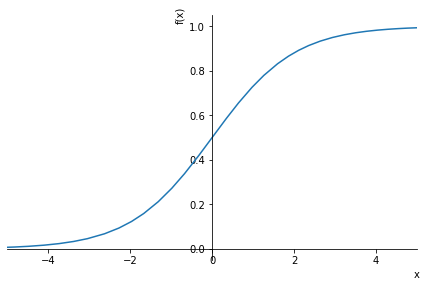

In [57]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

In [58]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [59]:
coeffs = train_model(lr=2)

0.510; 0.468; 0.397; 0.340; 0.309; 0.289; 0.268; 0.247; 0.230; 0.218; 0.210; 0.207; 0.205; 0.204; 0.204; 0.204; 0.204; 0.205; 0.205; 0.205; 0.205; 0.205; 0.205; 0.204; 0.203; 0.202; 0.201; 0.200; 0.198; 0.197; 

In [60]:
acc(coeffs)

tensor(0.8258)

In [61]:
show_coeffs()

{'Age': tensor(-1.6562),
 'SibSp': tensor(-1.1978),
 'Parch': tensor(-0.0264),
 'LogFare': tensor(2.0475),
 'Sex_male': tensor(-18.9596),
 'Sex_female': tensor(16.6258),
 'Pclass_1': tensor(7.8170),
 'Pclass_2': tensor(4.0900),
 'Pclass_3': tensor(-12.5817),
 'Embarked_C': tensor(3.1918),
 'Embarked_Q': tensor(1.0449),
 'Embarked_S': tensor(-5.8589)}

## Submitting to Kaggle

In [62]:
tst_df = pd.read_csv(path/'test.csv')

In [63]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [64]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [65]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [66]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [67]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


## Using matrix product

In [68]:
(val_indep*coeffs).sum(axis=1)

tensor([ 22.1141, -30.2821, -28.1549, -19.6869, -20.3803, -20.5681,   8.0241,  15.1430, -36.9090,   7.6186,
        -37.3447, -28.0859, -36.8184,   5.3086, -37.4433, -16.8453, -17.2593,  15.4162, -20.4547,  -1.7118,
        -37.1801, -17.0730,  28.2207,  15.0791, -37.1301, -30.0850,  -1.1708, -17.1972, -37.0081,   5.3037,
         15.3412,  -1.6341, -37.0766, -37.3090,  21.9898,  -1.3241, -16.8080,  28.5329, -37.1745,  -1.7640,
        -20.3206, -37.1745, -20.4117,  28.3984, -37.0917,  -1.4698, -36.6093, -37.0650, -30.3131,  -1.5780,
         -9.8281, -37.0747, -37.0533, -37.2336, -20.4656, -20.5898, -30.2817, -37.3746, -37.1124, -37.0589,
         -7.4700, -37.2175, -17.5311, -37.1169,  14.8775, -16.0102, -20.3596, -37.1497, -30.5589,  14.8026,
        -37.2215,   7.6448, -20.5691, -37.1257, -16.4180, -37.0190, -37.1745, -16.4581, -20.2561, -20.7920,
        -19.8429,  28.7201, -37.1594, -37.2048,  14.6230, -11.1232,  -6.9314,  19.7089,  24.2342, -20.3389,
        -37.3289, -37.1745, 

In [69]:
val_indep@coeffs

tensor([ 22.1141, -30.2821, -28.1549, -19.6869, -20.3803, -20.5681,   8.0241,  15.1430, -36.9090,   7.6186,
        -37.3447, -28.0859, -36.8184,   5.3086, -37.4433, -16.8453, -17.2593,  15.4162, -20.4547,  -1.7118,
        -37.1801, -17.0730,  28.2207,  15.0791, -37.1301, -30.0850,  -1.1708, -17.1972, -37.0081,   5.3037,
         15.3412,  -1.6341, -37.0766, -37.3090,  21.9898,  -1.3241, -16.8080,  28.5329, -37.1745,  -1.7640,
        -20.3206, -37.1745, -20.4117,  28.3984, -37.0917,  -1.4698, -36.6093, -37.0650, -30.3131,  -1.5780,
         -9.8282, -37.0747, -37.0533, -37.2336, -20.4656, -20.5898, -30.2817, -37.3746, -37.1124, -37.0589,
         -7.4700, -37.2175, -17.5311, -37.1169,  14.8775, -16.0102, -20.3596, -37.1497, -30.5589,  14.8026,
        -37.2215,   7.6448, -20.5691, -37.1257, -16.4180, -37.0190, -37.1745, -16.4581, -20.2561, -20.7920,
        -19.8429,  28.7201, -37.1594, -37.2048,  14.6230, -11.1232,  -6.9314,  19.7089,  24.2342, -20.3389,
        -37.3289, -37.1745, 

In [70]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In [71]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [72]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [74]:
coeffs = train_model(lr=2)

0.512; 0.470; 0.394; 0.331; 0.299; 0.280; 0.263; 0.245; 0.229; 0.217; 0.210; 0.206; 0.204; 0.203; 0.203; 0.203; 0.203; 0.203; 0.203; 0.204; 0.203; 0.203; 0.203; 0.202; 0.201; 0.200; 0.199; 0.198; 0.197; 0.196; 

In [75]:
acc(coeffs)

tensor(0.8258)

## A neural network

In [78]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [79]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [80]:
def update_coeffs(coeffs, lr):
    for layer in coeffs: layer.sub_(layer.grad * lr)

In [81]:
coeffs = train_model(lr=1.4)

0.543; 0.532; 0.509; 0.467; 0.396; 0.315; 0.271; 0.239; 0.213; 0.206; 0.208; 0.210; 0.211; 0.209; 0.203; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.193; 0.194; 0.193; 0.191; 0.191; 0.192; 0.192; 0.192; 0.192; 

In [82]:
acc(coeffs)

tensor(0.8258)

## Deep learning

In [83]:
hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want

In [83]:
sizes = [n_coeff] + hiddens + [1]

In [83]:
n = len(sizes)

In [83]:
layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]

In [83]:
consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]

In [83]:
for l in layers+consts: l.requires_grad_()
return layers,consts

In [83]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [84]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [85]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts: layer.sub_(layer.grad * lr)

In [86]:
coeffs = train_model(lr=1.4)

0.521; 0.462; 0.377; 0.370; 0.371; 0.350; 0.290; 0.196; 0.220; 0.223; 0.221; 0.218; 0.219; 0.218; 0.215; 0.214; 0.211; 0.201; 0.197; 0.199; 0.197; 0.194; 0.192; 0.192; 0.191; 0.191; 0.191; 0.190; 0.191; 0.192; 

In [87]:
acc(coeffs)

tensor(0.8258)

## Final thoughts